# Goal

* Extension of `Day1_rep10` simulations: subsampling OTU table without performing PCR simulation first
* Seeing how this affects the abundance distribution of the overlapping taxa in the dataset

## Init

In [1]:
import os
import glob
import re
import nestly

In [2]:
%load_ext rpy2.ipython
%load_ext pushnote

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Nestly

* assuming fragments already simulated
* assuming `Day1_rep10` notebook already ran

In [4]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'Day1_rep10')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile= '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags.pkl'
targetFile = '/home/nick/notebook/SIPSim/dev/fullCyc/CD-HIT/target_taxa.txt'

physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq_bulkCore = 'bulk-core'
physeq_SIP_core = 'SIP-core_unk'

nreps = 10
prefrac_comm_abundance = '1e9'

seq_per_fraction = ['lognormal', 9.432, 0.5, 10000, 30000] # dist, mean, scale, min, max
bulk_days = [1]
nprocs = 12

In [5]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('rep', [x + 1 for x in xrange(nreps)])

## set params
nest.add('bulk_day', bulk_days, create_dir=False)
nest.add('abs', [prefrac_comm_abundance], create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [nprocs], create_dir=False)
nest.add('subsample_dist', [seq_per_fraction[0]], create_dir=False)
nest.add('subsample_mean', [seq_per_fraction[1]], create_dir=False)
nest.add('subsample_scale', [seq_per_fraction[2]], create_dir=False)
nest.add('subsample_min', [seq_per_fraction[3]], create_dir=False)
nest.add('subsample_max', [seq_per_fraction[4]], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('targetFile', [targetFile], create_dir=False)
nest.add('physeqDir', [physeqDir], create_dir=False)
nest.add('physeq_bulkCore', [physeq_bulkCore], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [6]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH
  
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_meta.txt

Overwriting /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/SIPSimRun.sh


In [7]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d Day1_rep10 --log-file log.txt -j 2

2016-02-01 18:28:08,846 * INFO * Template: ./SIPSimRun.sh
2016-02-01 18:28:08,928 * INFO * [167134] Started ./SIPSimRun.sh in Day1_rep10/7
2016-02-01 18:28:14,583 * INFO * [167134] Day1_rep10/7 Finished with 0
2016-02-01 18:28:14,611 * INFO * [167180] Started ./SIPSimRun.sh in Day1_rep10/9
2016-02-01 18:28:18,302 * INFO * [167180] Day1_rep10/9 Finished with 0
2016-02-01 18:28:18,339 * INFO * [167226] Started ./SIPSimRun.sh in Day1_rep10/8
2016-02-01 18:28:21,941 * INFO * [167226] Day1_rep10/8 Finished with 0
2016-02-01 18:28:21,961 * INFO * [167272] Started ./SIPSimRun.sh in Day1_rep10/3
2016-02-01 18:28:25,572 * INFO * [167272] Day1_rep10/3 Finished with 0
2016-02-01 18:28:25,613 * INFO * [167318] Started ./SIPSimRun.sh in Day1_rep10/10
2016-02-01 18:28:29,048 * INFO * [167318] Day1_rep10/10 Finished with 0
2016-02-01 18:28:29,063 * INFO * [167365] Started ./SIPSimRun.sh in Day1_rep10/2
2016-02-01 18:28:32,939 * INFO * [167365] Day1_rep10/2 Finished with 0
2016-02-01 18:28:32,953 * IN

# BD min/max

* what is the min/max BD that we care about?

In [9]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Loading data

## Emperical

### SIP data

In [102]:
%%R -i physeqDir -i physeq_SIP_core -i bulk_days

# bulk core samples
F = file.path(physeqDir, physeq_SIP_core)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con' & 
                                physeq.SIP.core.m$Day %in% bulk_days, 
                                physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


In [103]:
%%R 

## dataframe
df.EMP = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.EMP$OTU = rownames(df.EMP)
df.EMP = df.EMP %>%    
    gather(sample, abundance, 1:(ncol(df.EMP)-1)) 

df.EMP = inner_join(df.EMP, physeq.SIP.core.m, c('sample' = 'X.Sample')) 

df.EMP.nt = df.EMP %>%
    group_by(sample) %>%
    mutate(n_taxa = sum(abundance > 0)) %>%
    ungroup() %>%
    distinct(sample) %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD)
    
df.EMP.nt %>% head(n=3)

Source: local data frame [3 x 20]

       OTU            sample abundance primer_number fwd_barcode rev_barcode
     (chr)             (chr)     (dbl)         (int)      (fctr)      (fctr)
1 OTU.1101 12C-Con.D1.R2_F23         2           134    TCGACGAG    TGAGTACG
2 OTU.1101 12C-Con.D1.R2_F18         0           129    CTACTATA    TGAGTACG
3 OTU.1101 12C-Con.D1.R2_F20         1           131    AGAGTCAC    TGAGTACG
Variables not shown: Substrate (fctr), Day (int), Microcosm_replicate (int),
  Fraction (int), Buoyant_density (dbl), Sample_type (fctr), library (fctr),
  Exp_type (fctr), Sample_location (lgl), Sample_date (lgl), Sample_treatment
  (lgl), Sample_subtreatment (lgl), core_dataset (lgl), n_taxa (int)


### bulk soil samples

In [104]:
%%R
physeq.dir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq.bulk = 'bulk-core'
physeq.file = file.path(physeq.dir, physeq.bulk)
physeq.bulk = readRDS(physeq.file)
physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk = prune_samples(physeq.bulk.m$Exp_type == 'microcosm_bulk' &
                            physeq.bulk.m$Day %in% bulk_days, physeq.bulk)

physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [105]:
%%R
physeq.bulk.n = transform_sample_counts(physeq.bulk, function(x) x/sum(x))
physeq.bulk.n

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [106]:
%%R
# making long format of each bulk table
bulk.otu = physeq.bulk.n %>% otu_table %>% as.data.frame
ncol = ncol(bulk.otu)
bulk.otu$OTU = rownames(bulk.otu)
bulk.otu = bulk.otu %>%
    gather(sample, abundance, 1:ncol) 

bulk.otu = inner_join(physeq.bulk.m, bulk.otu, c('X.Sample' = 'sample')) %>%
    dplyr::select(OTU, abundance) %>%
    rename('bulk_abund' = abundance)
bulk.otu %>% head(n=3)

       OTU   bulk_abund
1 OTU.1101 1.234263e-04
2 OTU.1130 6.171316e-05
3 OTU.9833 0.000000e+00


In [107]:
%%R
# joining tables
df.EMP.j = inner_join(df.EMP, bulk.otu, c('OTU' = 'OTU')) %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD) 
    
df.EMP.j %>% head(n=3)

       OTU            sample abundance primer_number fwd_barcode rev_barcode
1 OTU.1101 12C-Con.D1.R2_F23         2           134    TCGACGAG    TGAGTACG
2 OTU.1130 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
3 OTU.9833 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
  Substrate Day Microcosm_replicate Fraction Buoyant_density Sample_type
1   12C-Con   1                   2       23         1.69362     unknown
2   12C-Con   1                   2       23         1.69362     unknown
3   12C-Con   1                   2       23         1.69362     unknown
         library Exp_type Sample_location Sample_date Sample_treatment
1 150721_V4_Lib4      SIP              NA          NA               NA
2 150721_V4_Lib4      SIP              NA          NA               NA
3 150721_V4_Lib4      SIP              NA          NA               NA
  Sample_subtreatment core_dataset   bulk_abund
1                  NA         TRUE 1.234263e-04
2                  N

## Simulated

In [108]:
OTU_files = !find $buildDir -name "OTU_abs1e9_sub.txt"
#OTU_files = !find $buildDir -name "OTU_abs1e9.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/7/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/9/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/8/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/3/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/10/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/2/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/1/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/4/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/5/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/6/OTU_abs1e9_sub.txt']

In [114]:
%%R -i OTU_files
# loading files

df.SIM = list()
for (x in OTU_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/', '', x)
    #SIM_rep = gsub('/OTU_abs1e9_sub.txt', '', SIM_rep)
    SIM_rep = gsub('/OTU_abs1e9_sub.txt', '', SIM_rep)
    df.SIM[[SIM_rep]] = read.delim(x, sep='\t') 
    }
df.SIM = do.call('rbind', df.SIM)
df.SIM$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.SIM))
rownames(df.SIM) = 1:nrow(df.SIM)
df.SIM %>% head

  library    fraction taxon BD_min BD_mid BD_max count  rel_abund SIM_rep
1       1  -inf-1.660 OTU.1   -Inf  1.659  1.659   308 0.02363595       7
2       1 1.660-1.663 OTU.1  1.660  1.661  1.663   471 0.01973023       7
3       1 1.663-1.666 OTU.1  1.663  1.664  1.666   316 0.02160536       7
4       1 1.666-1.668 OTU.1  1.666  1.667  1.668   531 0.03296089       7
5       1 1.668-1.673 OTU.1  1.668  1.671  1.673   602 0.03757099       7
6       1 1.673-1.678 OTU.1  1.673  1.675  1.678   226 0.02221567       7


In [115]:
%%R
## edit table
df.SIM.nt = df.SIM %>%
    filter(count > 0) %>%
    group_by(SIM_rep, library, BD_mid) %>%
    summarize(n_taxa = n()) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
df.SIM.nt %>% head    

Source: local data frame [6 x 4]
Groups: SIM_rep, library [1]

  SIM_rep library BD_mid n_taxa
    (chr)   (int)  (dbl)  (int)
1       1       1  1.677   1715
2       1       1  1.681   1463
3       1       1  1.684   1116
4       1       1  1.687    540
5       1       1  1.690    398
6       1       1  1.693    402


### 'bulk soil' community files

In [116]:
# loading comm files
comm_files = !find $buildDir -name "bulk-core_comm_target.txt"
comm_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/7/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/9/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/8/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/3/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/10/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/2/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/1/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/4/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/5/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/ful

In [117]:
%%R -i comm_files

df.comm = list()
for (f in comm_files){
    rep = gsub('.+/Day1_rep10/([0-9]+)/.+', '\\1', f)
    df.comm[[rep]] = read.delim(f, sep='\t') %>%
        dplyr::select(library, taxon_name, rel_abund_perc) %>%
        rename('bulk_abund' = rel_abund_perc) %>%
        mutate(bulk_abund = bulk_abund / 100)
}

df.comm = do.call('rbind', df.comm)
df.comm$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.comm))
rownames(df.comm) = 1:nrow(df.comm)
df.comm %>% head(n=3)

  library taxon_name bulk_abund SIM_rep
1       1  OTU.14142 0.05918292       7
2       1      OTU.2 0.05856579       7
3       1  OTU.12920 0.04424833       7


In [118]:
%%R
## joining tables
df.SIM.j = inner_join(df.SIM, df.comm, c('SIM_rep' = 'SIM_rep',
                                         'library' = 'library',
                                         'taxon' = 'taxon_name')) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
    
df.SIM.j %>% head(n=3)

  library    fraction taxon BD_min BD_mid BD_max count   rel_abund SIM_rep
1       1 1.673-1.678 OTU.1  1.673  1.675  1.678   226 0.022215669       7
2       1 1.678-1.682 OTU.1  1.678  1.680  1.682   281 0.025545455       7
3       1 1.682-1.687 OTU.1  1.682  1.684  1.687   159 0.007709091       7
  bulk_abund
1 0.02801777
2 0.02801777
3 0.02801777


In [119]:
%%R 
# filtering & combining emperical w/ simulated data

## emperical 
max_BD_range = max(df.EMP.j$Buoyant_density) - min(df.EMP.j$Buoyant_density)
df.EMP.j.f = df.EMP.j %>%
    filter(abundance > 0) %>%
    group_by(OTU) %>%
    summarize(mean_rel_abund = mean(bulk_abund),
              min_BD = min(Buoyant_density),
              max_BD = max(Buoyant_density),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() %>%
    mutate(dataset = 'emperical',
           SIM_rep = NA)

## simulated
max_BD_range = max(df.SIM.j$BD_mid) - min(df.SIM.j$BD_mid)
df.SIM.j.f = df.SIM.j %>%
    filter(count > 0) %>%
    group_by(SIM_rep, taxon) %>%
    summarize(mean_rel_abund = mean(bulk_abund),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() %>%
    rename('OTU' = taxon) %>%
    mutate(dataset = 'simulated')

## join
df.j = rbind(df.EMP.j.f, df.SIM.j.f) %>%
    filter(BD_range_perc > 0,
            mean_rel_abund > 0)

df.j$SIM_rep = reorder(df.j$SIM_rep, df.j$SIM_rep %>% as.numeric)

df.j %>% head(n=3)

Source: local data frame [3 x 8]

      OTU mean_rel_abund   min_BD   max_BD   BD_range BD_range_perc   dataset
    (chr)          (dbl)    (dbl)    (dbl)      (dbl)         (dbl)     (chr)
1   OTU.1    0.028017773 1.676135 1.773391 0.09725564           100 emperical
2  OTU.10    0.001172550 1.676135 1.773391 0.09725564           100 emperical
3 OTU.100    0.001049124 1.676135 1.773391 0.09725564           100 emperical
Variables not shown: SIM_rep (fctr)


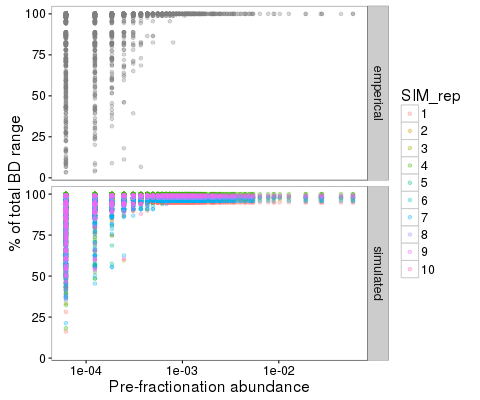

In [120]:
%%R -h 400
## plotting
ggplot(df.j, aes(mean_rel_abund, BD_range_perc, color=SIM_rep)) +
    geom_point(alpha=0.3) +
    scale_x_log10() +
    scale_y_continuous() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank()#,
        #legend.position = 'none'
        )


## BD span of just overlapping taxa

* Taxa overlapping between emperical data and genomes in dataset
* These taxa should have the same relative abundances in both datasets.
  * The comm file was created from the emperical dataset phyloseq file.

In [121]:
%%R -i targetFile

df.target = read.delim(targetFile, sep='\t')
df.target %>% nrow %>% print
df.target %>% head(n=3)

[1] 194
  cluster
1     212
2     762
3     663
                                                                                                   ssu_ID
1          rRNA_NC_014259_Acinetobacter_oleivorans_DR1__Acinetobacter_oleivorans_DR1_3479770-3481295_DIR-
2 rRNA_NC_019973_Mesorhizobium_australicum_WSM2073__Mesorhizobium_australicum_WSM207_1746046-1747518_DIR+
3  rRNA_NC_013037_Dyadobacter_fermentans_DSM_18053__Dyadobacter_fermentans_DSM_18053_4003859-4005353_DIR-
                                                                                         genome_fileID
1      /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/Acinetobacter_oleivorans_DR1.fna
2 /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/Mesorhizobium_australicum_WSM2073.fna
3  /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/Dyadobacter_fermentans_DSM_18053.fna
                           genomeID
1      Acinetobacter_oleivorans_DR1
2 Mesorhizobium_australicum_WSM2073
3  Dyado

[1] 21202
[1] 1014


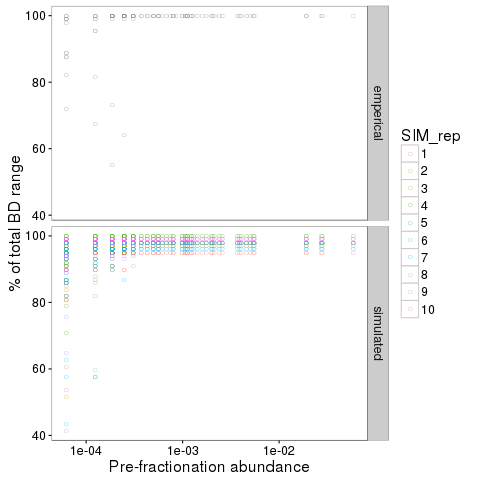

In [122]:
%%R
# filtering to just target taxa
df.j.t = df.j %>% 
    filter(OTU %in% df.target$OTU) 
df.j %>% nrow %>% print
df.j.t %>% nrow %>% print

## plotting
ggplot(df.j.t, aes(mean_rel_abund, BD_range_perc, color=SIM_rep)) +
    geom_point(alpha=0.5, shape='O') +
    scale_x_log10() +
    scale_y_continuous() +
    #scale_color_manual(values=c('blue', 'red')) +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank()#,
        #legend.position = 'none'
        )

### Correlation between relative abundance and BD_range diff

* Are low abundant taxa more variable in their BD span

In [123]:
%%R
# formatting data
df.1 = df.j.t %>% 
    filter(dataset == 'simulated') %>%
    select(SIM_rep, OTU, mean_rel_abund, BD_range, BD_range_perc)

df.2 = df.j.t %>%
    filter(dataset == 'emperical') %>%
    select(SIM_rep, OTU, mean_rel_abund, BD_range, BD_range_perc)

df.12 = inner_join(df.1, df.2, c('OTU' = 'OTU')) %>%
    mutate(BD_diff_perc = BD_range_perc.y - BD_range_perc.x)


df.12$SIM_rep.x = reorder(df.12$SIM_rep.x, df.12$SIM_rep.x  %>% as.numeric)

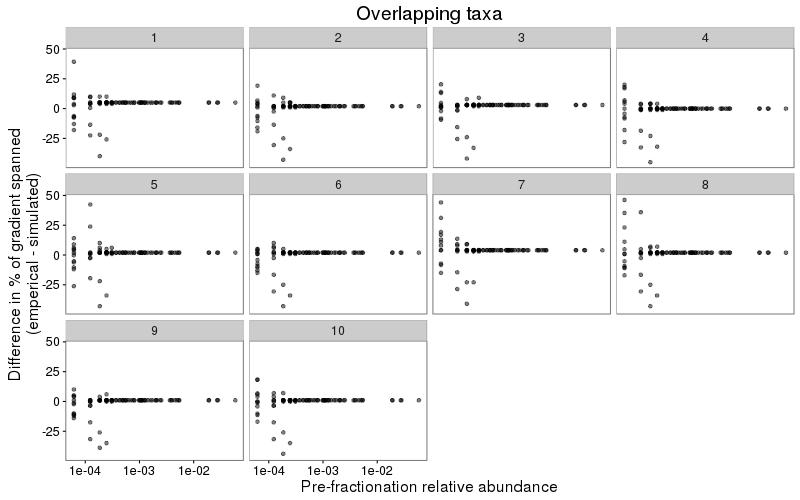

In [124]:
%%R -w 800 -h 500

ggplot(df.12, aes(mean_rel_abund.x, BD_diff_perc)) +
    geom_point(alpha=0.5) +
    scale_x_log10() +
    labs(x='Pre-fractionation relative abundance', 
         y='Difference in % of gradient spanned\n(emperical - simulated)',
         title='Overlapping taxa') +
    facet_wrap(~ SIM_rep.x) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )


#### Notes

* between Day1_rep10, Day1_richFromTarget_rep10, and Day1_add_Rich_rep10:
  * Day1_rep10 has the most accurate representation of BD span (% of gradient spanned by taxa).
    * Accuracy drops at ~1e-3 to ~5e-4, but this is caused by detection limits (veil-line effect).

# Comparing abundance distributions of overlapping taxa

In [125]:
%%R

join_abund_dists = function(df.EMP.j, df.SIM.j, df.target){
    
    ## emperical 
    df.EMP.j.f = df.EMP.j %>%
        filter(abundance > 0) %>%
        #filter(!OTU %in% c('OTU.32', 'OTU.2', 'OTU.4')) %>%   # TEST
        dplyr::select(OTU, sample, abundance, Buoyant_density, bulk_abund) %>%
        mutate(dataset = 'emperical', SIM_rep = NA) %>%
        filter(OTU %in% df.target$OTU) 
    
    ## simulated
    df.SIM.j.f = df.SIM.j %>%
        filter(count > 0) %>%
        #filter(!taxon %in% c('OTU.32', 'OTU.2', 'OTU.4')) %>%   # TEST
        dplyr::select(taxon, fraction, count, BD_mid, bulk_abund, SIM_rep) %>%
        rename('OTU' = taxon,
               'sample' = fraction,
               'Buoyant_density' = BD_mid,
               'abundance' = count) %>%
        mutate(dataset = 'simulated') %>%
        filter(OTU %in% df.target$OTU) 
    
    ## getting just intersecting OTUs
    OTUs.int = intersect(df.EMP.j.f$OTU, df.SIM.j.f$OTU)
    
    df.j = rbind(df.EMP.j.f, df.SIM.j.f) %>%
        filter(OTU %in% OTUs.int) %>%
        group_by(sample) %>%
        mutate(rel_abund = abundance / sum(abundance))
    
    cat('Number of overlapping OTUs between emperical & simulated:', 
            df.j$OTU %>% unique %>% length, '\n\n')
    return(df.j)
    }


df.j = join_abund_dists(df.EMP.j, df.SIM.j, df.target)
df.j %>% head(n=3) %>% as.data.frame                  

Number of overlapping OTUs between emperical & simulated: 92 

      OTU            sample abundance Buoyant_density   bulk_abund   dataset
1 OTU.170 12C-Con.D1.R2_F23         2         1.69362 0.0005554184 emperical
2  OTU.24 12C-Con.D1.R2_F23        25         1.69362 0.0020982473 emperical
3  OTU.11 12C-Con.D1.R2_F23         4         1.69362 0.0004319921 emperical
  SIM_rep    rel_abund
1    <NA> 0.0006006006
2    <NA> 0.0075075075
3    <NA> 0.0012012012


In [126]:
%%R
# closure operation
df.j = df.j %>%
    ungroup() %>%
    mutate(SIM_rep = SIM_rep %>% as.numeric) %>%
    group_by(dataset, SIM_rep, sample) %>%
    mutate(rel_abund_c = rel_abund / sum(rel_abund)) %>%
    ungroup()

df.j %>% head(n=3) %>% as.data.frame

      OTU            sample abundance Buoyant_density   bulk_abund   dataset
1 OTU.170 12C-Con.D1.R2_F23         2         1.69362 0.0005554184 emperical
2  OTU.24 12C-Con.D1.R2_F23        25         1.69362 0.0020982473 emperical
3  OTU.11 12C-Con.D1.R2_F23         4         1.69362 0.0004319921 emperical
  SIM_rep    rel_abund  rel_abund_c
1      NA 0.0006006006 0.0006006006
2      NA 0.0075075075 0.0075075075
3      NA 0.0012012012 0.0012012012


Number of overlapping taxa: 92 


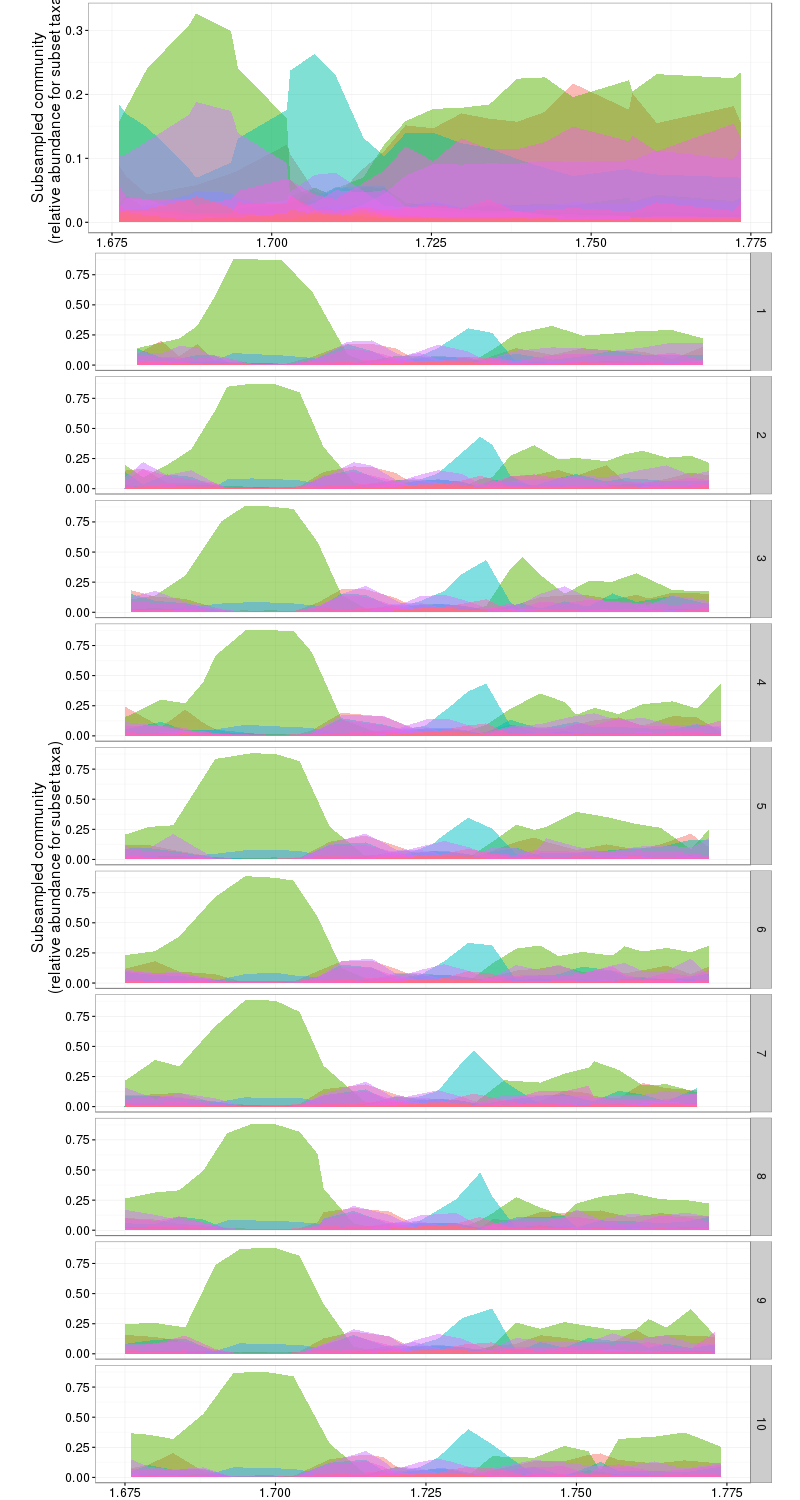

In [127]:
%%R -h 1500 -w 800
# plotting 
plot_abunds = function(df){
    p = ggplot(df, aes(Buoyant_density, rel_abund_c, fill=OTU)) +
        geom_area(stat='identity', position='dodge', alpha=0.5) +
        labs(x='Buoyant density', 
             y='Subsampled community\n(relative abundance for subset taxa)') +
        theme_bw() +
        theme( 
            text = element_text(size=16),
            legend.position = 'none',
              axis.title.y = element_text(vjust=1),        
              axis.title.x = element_blank(),
              plot.margin=unit(c(0.1,1,0.1,1), "cm")
             )
    return(p)
    }


# simulations
df.j.f = df.j %>%
    filter(dataset == 'simulated')
p.SIM = plot_abunds(df.j.f)
p.SIM = p.SIM + facet_grid(SIM_rep ~ .)

# emperical
df.j.f = df.j %>%
    filter(dataset == 'emperical')
p.EMP = plot_abunds(df.j.f)

# status
cat('Number of overlapping taxa:', df.j$OTU %>% unique %>% length, '\n')

# make figure
grid.arrange(p.EMP, p.SIM, ncol=1, heights=c(1,5))

# Calculating center of mass for overlapping taxa

* weighted mean BD, where weights are relative abundances

In [128]:
%%R

center_mass = function(df){
    df = df %>%
        group_by(dataset, SIM_rep, OTU) %>%
        summarize(center_mass = weighted.mean(Buoyant_density, rel_abund_c, na.rm=T),
                  median_rel_abund_c = median(rel_abund_c)) %>%
        ungroup()
    return(df)
}

df.j.cm = center_mass(df.j) 

Number of OTUs: 92 


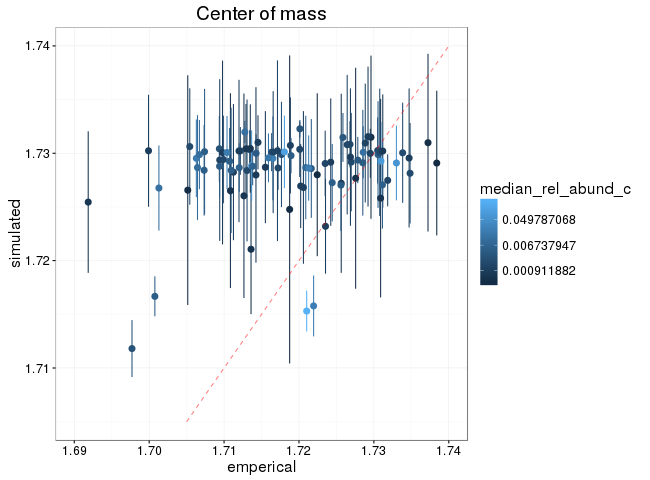

In [129]:
%%R -w 650
# getting mean cm for all SIM_reps
df.j.cm.s = df.j.cm %>%
    group_by(dataset, OTU) %>%
    summarize(mean_cm = mean(center_mass, na.rm=T),
              stdev_cm = sd(center_mass),
              median_rel_abund_c = first(median_rel_abund_c)) %>%
    ungroup() %>%
    spread(dataset, mean_cm) %>%
    group_by(OTU) %>%
    summarize(stdev_cm = mean(stdev_cm, na.rm=T),
              emperical = mean(emperical, na.rm=T),
              simulated = mean(simulated, na.rm=T),
              median_rel_abund_c = first(median_rel_abund_c)) %>%
    ungroup()

# check
cat('Number of OTUs:', df.j.cm.s$OTU %>% unique %>% length, '\n')

# plotting
ggplot(df.j.cm.s, aes(emperical, simulated, color=median_rel_abund_c,
                    ymin = simulated - stdev_cm,
                    ymax = simulated + stdev_cm)) +
    geom_pointrange() +
    stat_function(fun = function(x) x, linetype='dashed', alpha=0.5, color='red') +
    scale_x_continuous(limits=c(1.69, 1.74)) +
    scale_y_continuous(limits=c(1.705, 1.74)) +
    scale_color_gradient(trans='log') +
    labs(title='Center of mass') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* Leaving out the PCR simulation does not help with simulation accuracy for center of mass on overlapping taxa

### plotting taxon abundance vs diff between emperical & simulated

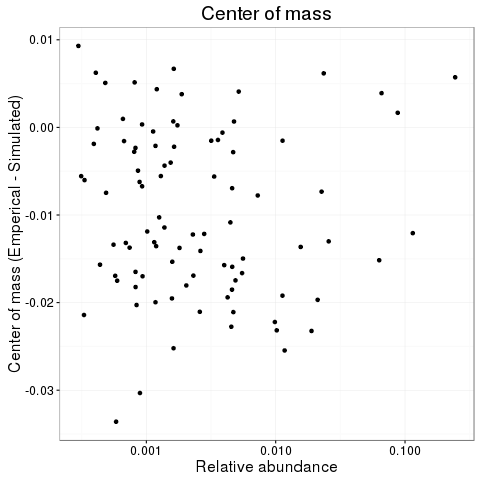

In [130]:
%%R

df.j.cm.s.f = df.j.cm.s %>%
    mutate(CM_diff = emperical - simulated)

ggplot(df.j.cm.s.f, aes(median_rel_abund_c, CM_diff)) +
    geom_point() +
    scale_x_log10() +
    labs(x='Relative abundance', y='Center of mass (Emperical - Simulated)', title='Center of mass') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* No clear pattern between OTU relative abundance (relative for just the overlapping taxa) and the difference in center between simulated and emperical data

# What is causing the inter-SIM_rep varition in center of mass?

**possibilities:**

1. subsampling simulation
  * definately contributes to a lot of the variation (re-ran the above cells with the OTU table files)
  * the samples then become more centered around a BD of 1.725 (approx. center of gradient)
    * This suggests that the DBL is causing too much smearing. 
    * Need to try a run w/out DBL 
2. DBL 'smearing' simultion
3. diffusion simulation